In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! ls '/content/drive/MyDrive/Satellite Semantic Segmentation'

attention_unet_train.ipynb  data.ipynb	     readme_images     runs		  unet_train.ipynb
config			    models	     README.md	       src
data			    MODELS_REGISTER  requirements.txt  test_inference.py


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Satellite Semantic Segmentation')

In [4]:
! pip install -r "/content/drive/MyDrive/Satellite Semantic Segmentation/requirements.txt"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.6/181.6 kB 14.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 80.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 92.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 102.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [5]:
base_path = "/content/drive/MyDrive/Satellite Semantic Segmentation/"

In [6]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchinfo import summary

from matplotlib import pyplot as plt
from timeit import default_timer as timer
import random

from config import data_config, attention_unet_config

from src.utils import *
from src.datafactory import SatelliteDataset, SatellitePatchesDataset, create_dataloaders
from src import engine
from models.attentionunet import AttentionUnet
from src.transforms import train_transforms, val_transforms

import logging

from codecarbon import EmissionsTracker

## Disable logging from codecarbon
logging.getLogger("codecarbon").setLevel(logging.CRITICAL)

In [7]:
from torch.utils.tensorboard import SummaryWriter

In [8]:
NUM_WORKERS = os.cpu_count()

# Setup data configs
data_config = data_config.data_config()

# Setup hyperparameters
att_unet_hyperparams = attention_unet_config.attention_unet_config()

seed_everything(seed = att_unet_hyperparams.global_seed)


# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(base_path + att_unet_hyperparams.LOGS_DIR)

# Setup device-agnostic code
# device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device = ", att_unet_hyperparams.DEVICE)

Device =  cuda


### Load Patch Images

In [9]:

patches_images = torch.load(base_path + data_config.PATCHES_DATA_PATH + 'patches_images.pt')
patches_masks = torch.load(base_path + data_config.PATCHES_DATA_PATH + 'patches_masks.pt')

print(patches_images.shape, patches_masks.shape)

(1305, 256, 256, 3) (1305, 256, 256)


### Visualize Patches Images

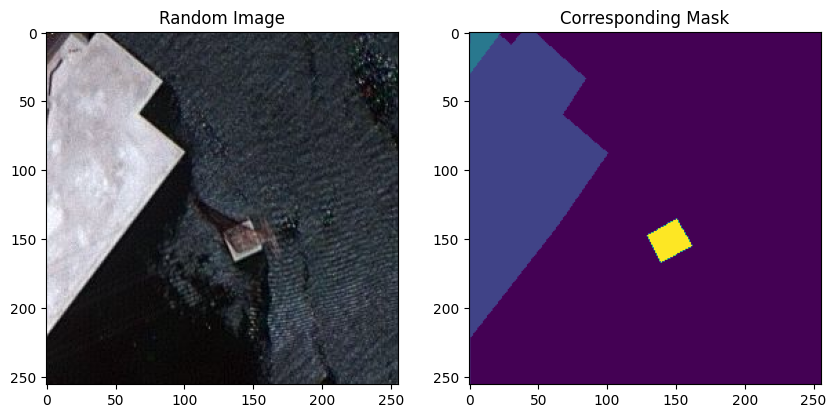

In [10]:
display_random_image_and_mask(patches_images, patches_masks,tensorboard_writer=writer)

### Load Train, Val and Test sets

In [11]:
Xtrain_patches = torch.load(base_path + data_config.TRAIN_DATA_PATH + 'Xtrain_patches.pt')
ytrain_patches = torch.load(base_path + data_config.TRAIN_DATA_PATH + 'ytrain_patches.pt')

Xval_patches = torch.load(base_path + data_config.VAL_DATA_PATH + 'Xval_patches.pt')
yval_patches = torch.load(base_path + data_config.VAL_DATA_PATH + 'yval_patches.pt')

Xtest_patches = torch.load(base_path + data_config.TEST_DATA_PATH + 'Xtest_patches.pt')
ytest_patches  = torch.load(base_path + data_config.TEST_DATA_PATH + 'ytest_patches.pt')

Xtrain_patches.shape, Xval_patches.shape, Xtest_patches.shape, ytrain_patches.shape, yval_patches.shape, ytest_patches.shape

((913, 256, 256, 3),
 (261, 256, 256, 3),
 (131, 256, 256, 3),
 (913, 256, 256),
 (261, 256, 256),
 (131, 256, 256))

In [12]:
ytrain_patches[0]

array([[3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

### Setup data transformation

### Instantiate train and test dataset

In [13]:
train_dataset = SatellitePatchesDataset(patches_images=Xtrain_patches,
                  patches_masks=ytrain_patches,
                  transform=train_transforms)

val_dataset = SatellitePatchesDataset(patches_images= Xval_patches,
                  patches_masks= yval_patches,
                  transform=val_transforms)

test_dataset = SatellitePatchesDataset(patches_images= Xtest_patches,
                  patches_masks= ytest_patches,
                  transform=val_transforms)

In [14]:
random.seed(42)
visualize_augmentations(train_dataset, idx=55)

Output hidden; open in https://colab.research.google.com to view.

### Create Train & Test dataloaders

In [15]:
train_dataloader = create_dataloaders(dataset=train_dataset,
                                      batch_size= att_unet_hyperparams.BATCH_SIZE,
                                      num_workers=NUM_WORKERS,)

val_dataloader = create_dataloaders(dataset=val_dataset,
                                     batch_size= att_unet_hyperparams.BATCH_SIZE,
                                     num_workers=NUM_WORKERS,)

test_dataloader = create_dataloaders(dataset=test_dataset,
                                     batch_size= att_unet_hyperparams.BATCH_SIZE,
                                     num_workers=NUM_WORKERS,)

In [16]:
batchX0, batchy0 = next(iter(train_dataloader))
batchX0.shape, batchy0.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32, 256, 256]))

In [17]:
batchy0[0].unique()

tensor([1., 2., 3.], dtype=torch.float64)

### Intanciate Model and add graph to tensorboard

In [18]:
model = AttentionUnet(in_channels = att_unet_hyperparams.IN_CHANNELS,
             n_classes = att_unet_hyperparams.NUM_CLASSES,
             level_channels = att_unet_hyperparams.LEVEL_CHANNELS,
             bottleneck_channel = att_unet_hyperparams.BOTTLENECK_CHANNEL,).to(att_unet_hyperparams.DEVICE)

input_example = torch.randn((2, 3, 256, 256)).to(att_unet_hyperparams.DEVICE)
writer.add_graph(model, input_example)

summary(model, input_size=input_example.shape)

Layer (type:depth-idx)                   Output Shape              Param #
AttentionUnet                            [2, 6, 256, 256]          --
├─encoder_block: 1-1                     [2, 64, 256, 256]         --
│    └─conv_block: 2-1                   [2, 64, 256, 256]         --
│    │    └─Sequential: 3-1              [2, 64, 256, 256]         38,976
│    └─MaxPool2d: 2-2                    [2, 64, 128, 128]         --
├─encoder_block: 1-2                     [2, 128, 128, 128]        --
│    └─conv_block: 2-3                   [2, 128, 128, 128]        --
│    │    └─Sequential: 3-2              [2, 128, 128, 128]        221,952
│    └─MaxPool2d: 2-4                    [2, 128, 64, 64]          --
├─encoder_block: 1-3                     [2, 256, 64, 64]          --
│    └─conv_block: 2-5                   [2, 256, 64, 64]          --
│    │    └─Sequential: 3-3              [2, 256, 64, 64]          886,272
│    └─MaxPool2d: 2-6                    [2, 256, 32, 32]          --
├

### Start training with help from engine.py


In [ ]:

# setup CO2 emissions tracker
tracker = EmissionsTracker()
tracker.start()

# Start the timer
start_time = timer()

results = engine.train(model=model,
             train_loader=train_dataloader,
             val_loader=test_dataloader,
             optimizer=att_unet_hyperparams.OPTIMIZER(model.parameters(), lr=att_unet_hyperparams.LEARNING_RATE),
             criterion= att_unet_hyperparams.LOSS_FN,
             metrics=att_unet_hyperparams.METRICS,
             num_classes=att_unet_hyperparams.NUM_CLASSES,
             num_epochs=att_unet_hyperparams.NUM_EPOCHS,
             tensorboard_writer=writer,
             device=att_unet_hyperparams.DEVICE)

end_time = timer()

emissions: float = tracker.stop()

writer.flush()

[codecarbon INFO @ 15:24:26] [setup] RAM Tracking...
[codecarbon INFO @ 15:24:26] [setup] GPU Tracking...
[codecarbon INFO @ 15:24:26] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 15:24:26] [setup] CPU Tracking...
[codecarbon WARNING @ 15:24:26] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 15:24:28] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 15:24:28] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 15:24:28] >>> Tracker's metadata:
[codecarbon INFO @ 15:24:28]   Platform system: Linux-6.1.58+-x86_64-with-glibc2.35
[codecarbon INFO @ 15:24:28]   Python version: 3.10.12
[codecarbon INFO @ 15:24:28]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 15:24:28]   Available RAM : 83.477 GB
[codecarbon INFO @ 15:24:28]   CPU count: 12
[codecarbon INFO @ 15:24:28]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 15:24:28]   GPU 


Epoch 1/100 - Training Loss: 1.5102 - Validation Loss: 1.4434
Train Dice Coeff.: 0.5026 - Val Dice Coeff.: 0.5026


[codecarbon INFO @ 15:24:43] Energy consumed for RAM : 0.000130 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:24:43] Energy consumed for all GPUs : 0.000880 kWh. Total GPU Power : 211.0631517987904 W
[codecarbon INFO @ 15:24:43] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:24:43] 0.001188 kWh of electricity used since the beginning.
  2%|▏         | 2/100 [00:25<20:17, 12.42s/it]


Epoch 2/100 - Training Loss: 1.3364 - Validation Loss: 1.2944
Train Dice Coeff.: 0.5988 - Val Dice Coeff.: 0.5988


[codecarbon INFO @ 15:24:58] Energy consumed for RAM : 0.000261 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:24:58] Energy consumed for all GPUs : 0.002029 kWh. Total GPU Power : 275.9215491404601 W
[codecarbon INFO @ 15:24:58] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:24:58] 0.002644 kWh of electricity used since the beginning.
  3%|▎         | 3/100 [00:36<19:15, 11.91s/it]


Epoch 3/100 - Training Loss: 1.3270 - Validation Loss: 1.1939
Train Dice Coeff.: 0.5342 - Val Dice Coeff.: 0.5342


[codecarbon INFO @ 15:25:13] Energy consumed for RAM : 0.000391 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:25:13] Energy consumed for all GPUs : 0.003193 kWh. Total GPU Power : 279.358457593449 W
[codecarbon INFO @ 15:25:13] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:25:13] 0.004115 kWh of electricity used since the beginning.
  4%|▍         | 4/100 [00:47<18:44, 11.71s/it]


Epoch 4/100 - Training Loss: 1.2740 - Validation Loss: 0.9823
Train Dice Coeff.: 0.6031 - Val Dice Coeff.: 0.6031


  5%|▌         | 5/100 [00:59<18:22, 11.61s/it]


Epoch 5/100 - Training Loss: 1.2419 - Validation Loss: 1.1022
Train Dice Coeff.: 0.5902 - Val Dice Coeff.: 0.5902


[codecarbon INFO @ 15:25:28] Energy consumed for RAM : 0.000522 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:25:28] Energy consumed for all GPUs : 0.004259 kWh. Total GPU Power : 255.9824698029231 W
[codecarbon INFO @ 15:25:28] Energy consumed for all CPUs : 0.000709 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:25:28] 0.005490 kWh of electricity used since the beginning.
  6%|▌         | 6/100 [01:10<18:00, 11.50s/it]


Epoch 6/100 - Training Loss: 1.2978 - Validation Loss: 1.1384
Train Dice Coeff.: 0.5788 - Val Dice Coeff.: 0.5788


[codecarbon INFO @ 15:25:43] Energy consumed for RAM : 0.000652 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:25:43] Energy consumed for all GPUs : 0.005410 kWh. Total GPU Power : 276.53524550984736 W
[codecarbon INFO @ 15:25:43] Energy consumed for all CPUs : 0.000886 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:25:43] 0.006947 kWh of electricity used since the beginning.
  7%|▋         | 7/100 [01:22<17:47, 11.48s/it]


Epoch 7/100 - Training Loss: 1.2557 - Validation Loss: 1.3370
Train Dice Coeff.: 0.5810 - Val Dice Coeff.: 0.5810


[codecarbon INFO @ 15:25:58] Energy consumed for RAM : 0.000782 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:25:58] Energy consumed for all GPUs : 0.006588 kWh. Total GPU Power : 282.9278694713104 W
[codecarbon INFO @ 15:25:58] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:25:58] 0.008433 kWh of electricity used since the beginning.
  8%|▊         | 8/100 [01:33<17:34, 11.46s/it]


Epoch 8/100 - Training Loss: 1.2420 - Validation Loss: 1.0976
Train Dice Coeff.: 0.6250 - Val Dice Coeff.: 0.6250


  9%|▉         | 9/100 [01:44<17:19, 11.43s/it]


Epoch 9/100 - Training Loss: 1.1817 - Validation Loss: 1.1068
Train Dice Coeff.: 0.6160 - Val Dice Coeff.: 0.6160


[codecarbon INFO @ 15:26:13] Energy consumed for RAM : 0.000913 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:26:13] Energy consumed for all GPUs : 0.007701 kWh. Total GPU Power : 266.1928626976445 W
[codecarbon INFO @ 15:26:13] Energy consumed for all CPUs : 0.001241 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:26:13] 0.009855 kWh of electricity used since the beginning.
 10%|█         | 10/100 [01:56<17:12, 11.47s/it]


Epoch 10/100 - Training Loss: 1.2092 - Validation Loss: 1.1394
Train Dice Coeff.: 0.6199 - Val Dice Coeff.: 0.6199


[codecarbon INFO @ 15:26:28] Energy consumed for RAM : 0.001042 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:26:28] Energy consumed for all GPUs : 0.008809 kWh. Total GPU Power : 268.11309662090787 W
[codecarbon INFO @ 15:26:28] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:26:28] 0.011267 kWh of electricity used since the beginning.
 11%|█         | 11/100 [02:07<17:02, 11.48s/it]


Epoch 11/100 - Training Loss: 1.2412 - Validation Loss: 0.9876
Train Dice Coeff.: 0.6225 - Val Dice Coeff.: 0.6225


[codecarbon INFO @ 15:26:43] Energy consumed for RAM : 0.001172 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:26:43] Energy consumed for all GPUs : 0.009994 kWh. Total GPU Power : 284.6814675542424 W
[codecarbon INFO @ 15:26:43] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:26:43] 0.012760 kWh of electricity used since the beginning.
 12%|█▏        | 12/100 [02:19<16:46, 11.44s/it]


Epoch 12/100 - Training Loss: 1.1855 - Validation Loss: 1.0672
Train Dice Coeff.: 0.6179 - Val Dice Coeff.: 0.6179


[codecarbon INFO @ 15:26:58] Energy consumed for RAM : 0.001302 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:26:58] Energy consumed for all GPUs : 0.011130 kWh. Total GPU Power : 272.5996756550232 W
[codecarbon INFO @ 15:26:58] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:26:58] 0.014203 kWh of electricity used since the beginning.
 13%|█▎        | 13/100 [02:30<16:36, 11.46s/it]


Epoch 13/100 - Training Loss: 1.2124 - Validation Loss: 1.0990
Train Dice Coeff.: 0.6075 - Val Dice Coeff.: 0.6075


 14%|█▍        | 14/100 [02:42<16:27, 11.48s/it]


Epoch 14/100 - Training Loss: 1.1939 - Validation Loss: 1.0612
Train Dice Coeff.: 0.6331 - Val Dice Coeff.: 0.6331


[codecarbon INFO @ 15:27:13] Energy consumed for RAM : 0.001433 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:27:13] Energy consumed for all GPUs : 0.012205 kWh. Total GPU Power : 258.22496172450803 W
[codecarbon INFO @ 15:27:13] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:27:13] 0.015586 kWh of electricity used since the beginning.
 15%|█▌        | 15/100 [02:53<16:18, 11.51s/it]


Epoch 15/100 - Training Loss: 1.1510 - Validation Loss: 0.9396
Train Dice Coeff.: 0.6026 - Val Dice Coeff.: 0.6026


[codecarbon INFO @ 15:27:28] Energy consumed for RAM : 0.001563 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:27:28] Energy consumed for all GPUs : 0.013384 kWh. Total GPU Power : 282.9392684394103 W
[codecarbon INFO @ 15:27:28] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:27:28] 0.017072 kWh of electricity used since the beginning.
 16%|█▌        | 16/100 [03:05<16:08, 11.53s/it]


Epoch 16/100 - Training Loss: 1.1532 - Validation Loss: 1.0776
Train Dice Coeff.: 0.6416 - Val Dice Coeff.: 0.6416


[codecarbon INFO @ 15:27:43] Energy consumed for RAM : 0.001693 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:27:43] Energy consumed for all GPUs : 0.014571 kWh. Total GPU Power : 284.9437747565793 W
[codecarbon INFO @ 15:27:43] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:27:43] 0.018566 kWh of electricity used since the beginning.
 17%|█▋        | 17/100 [03:16<15:55, 11.51s/it]


Epoch 17/100 - Training Loss: 1.1588 - Validation Loss: 0.9971
Train Dice Coeff.: 0.5994 - Val Dice Coeff.: 0.5994


 18%|█▊        | 18/100 [03:28<15:41, 11.48s/it]


Epoch 18/100 - Training Loss: 1.0997 - Validation Loss: 1.2618
Train Dice Coeff.: 0.6149 - Val Dice Coeff.: 0.6149


[codecarbon INFO @ 15:27:58] Energy consumed for RAM : 0.001824 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:27:58] Energy consumed for all GPUs : 0.015630 kWh. Total GPU Power : 254.30310010396812 W
[codecarbon INFO @ 15:27:58] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:27:58] 0.019933 kWh of electricity used since the beginning.
 19%|█▉        | 19/100 [03:39<15:27, 11.46s/it]


Epoch 19/100 - Training Loss: 1.1213 - Validation Loss: 0.8862
Train Dice Coeff.: 0.6223 - Val Dice Coeff.: 0.6223


[codecarbon INFO @ 15:28:13] Energy consumed for RAM : 0.001954 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:28:13] Energy consumed for all GPUs : 0.016818 kWh. Total GPU Power : 285.1411073650696 W
[codecarbon INFO @ 15:28:13] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:28:13] 0.021428 kWh of electricity used since the beginning.
 20%|██        | 20/100 [03:51<15:14, 11.43s/it]


Epoch 20/100 - Training Loss: 1.1046 - Validation Loss: 0.9157
Train Dice Coeff.: 0.6513 - Val Dice Coeff.: 0.6513


[codecarbon INFO @ 15:28:28] Energy consumed for RAM : 0.002084 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:28:28] Energy consumed for all GPUs : 0.018023 kWh. Total GPU Power : 289.42501052344926 W
[codecarbon INFO @ 15:28:28] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:28:28] 0.022940 kWh of electricity used since the beginning.
 21%|██        | 21/100 [04:02<15:00, 11.40s/it]


Epoch 21/100 - Training Loss: 1.1157 - Validation Loss: 1.1062
Train Dice Coeff.: 0.6129 - Val Dice Coeff.: 0.6129


 22%|██▏       | 22/100 [04:13<14:49, 11.41s/it]


Epoch 22/100 - Training Loss: 1.0829 - Validation Loss: 0.8963
Train Dice Coeff.: 0.6599 - Val Dice Coeff.: 0.6599


[codecarbon INFO @ 15:28:43] Energy consumed for RAM : 0.002215 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:28:43] Energy consumed for all GPUs : 0.019078 kWh. Total GPU Power : 253.25172691346614 W
[codecarbon INFO @ 15:28:43] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:28:43] 0.024303 kWh of electricity used since the beginning.
 23%|██▎       | 23/100 [04:25<14:40, 11.44s/it]


Epoch 23/100 - Training Loss: 1.1197 - Validation Loss: 0.9187
Train Dice Coeff.: 0.6497 - Val Dice Coeff.: 0.6497


[codecarbon INFO @ 15:28:58] Energy consumed for RAM : 0.002345 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:28:58] Energy consumed for all GPUs : 0.020260 kWh. Total GPU Power : 283.8833908829423 W
[codecarbon INFO @ 15:28:58] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:28:58] 0.025792 kWh of electricity used since the beginning.
 24%|██▍       | 24/100 [04:36<14:30, 11.46s/it]


Epoch 24/100 - Training Loss: 1.0951 - Validation Loss: 0.9807
Train Dice Coeff.: 0.6459 - Val Dice Coeff.: 0.6459


[codecarbon INFO @ 15:29:13] Energy consumed for RAM : 0.002475 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:29:13] Energy consumed for all GPUs : 0.021447 kWh. Total GPU Power : 284.99005673395607 W
[codecarbon INFO @ 15:29:13] Energy consumed for all CPUs : 0.003364 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:29:13] 0.027287 kWh of electricity used since the beginning.
 25%|██▌       | 25/100 [04:48<14:20, 11.48s/it]


Epoch 25/100 - Training Loss: 1.0581 - Validation Loss: 0.9729
Train Dice Coeff.: 0.6332 - Val Dice Coeff.: 0.6332


 26%|██▌       | 26/100 [04:59<14:06, 11.44s/it]


Epoch 26/100 - Training Loss: 1.0946 - Validation Loss: 0.9581
Train Dice Coeff.: 0.6279 - Val Dice Coeff.: 0.6279


[codecarbon INFO @ 15:29:28] Energy consumed for RAM : 0.002606 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:29:28] Energy consumed for all GPUs : 0.022571 kWh. Total GPU Power : 269.5560100957345 W
[codecarbon INFO @ 15:29:28] Energy consumed for all CPUs : 0.003542 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:29:28] 0.028719 kWh of electricity used since the beginning.
 27%|██▋       | 27/100 [05:11<13:55, 11.44s/it]


Epoch 27/100 - Training Loss: 1.0426 - Validation Loss: 0.8345
Train Dice Coeff.: 0.6546 - Val Dice Coeff.: 0.6546


[codecarbon INFO @ 15:29:43] Energy consumed for RAM : 0.002736 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:29:43] Energy consumed for all GPUs : 0.023712 kWh. Total GPU Power : 275.5897907877869 W
[codecarbon INFO @ 15:29:43] Energy consumed for all CPUs : 0.003718 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:29:43] 0.030165 kWh of electricity used since the beginning.
 28%|██▊       | 28/100 [05:22<13:41, 11.41s/it]


Epoch 28/100 - Training Loss: 1.0610 - Validation Loss: 1.1001
Train Dice Coeff.: 0.6315 - Val Dice Coeff.: 0.6315


[codecarbon INFO @ 15:29:58] Energy consumed for RAM : 0.002866 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:29:58] Energy consumed for all GPUs : 0.024900 kWh. Total GPU Power : 285.2678890925982 W
[codecarbon INFO @ 15:29:58] Energy consumed for all CPUs : 0.003895 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:29:58] 0.031661 kWh of electricity used since the beginning.
 29%|██▉       | 29/100 [05:34<13:30, 11.42s/it]


Epoch 29/100 - Training Loss: 1.0655 - Validation Loss: 1.0400
Train Dice Coeff.: 0.6650 - Val Dice Coeff.: 0.6650


[codecarbon INFO @ 15:30:13] Energy consumed for RAM : 0.002996 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:30:13] Energy consumed for all GPUs : 0.026027 kWh. Total GPU Power : 270.6925296026402 W
[codecarbon INFO @ 15:30:13] Energy consumed for all CPUs : 0.004072 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:30:13] 0.033096 kWh of electricity used since the beginning.
 30%|███       | 30/100 [05:45<13:20, 11.44s/it]


Epoch 30/100 - Training Loss: 1.0444 - Validation Loss: 0.9474
Train Dice Coeff.: 0.6489 - Val Dice Coeff.: 0.6489


 31%|███       | 31/100 [05:56<13:07, 11.41s/it]


Epoch 31/100 - Training Loss: 1.0285 - Validation Loss: 0.8548
Train Dice Coeff.: 0.6542 - Val Dice Coeff.: 0.6542


[codecarbon INFO @ 15:30:28] Energy consumed for RAM : 0.003127 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:30:28] Energy consumed for all GPUs : 0.027136 kWh. Total GPU Power : 266.0441695621733 W
[codecarbon INFO @ 15:30:28] Energy consumed for all CPUs : 0.004249 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:30:28] 0.034511 kWh of electricity used since the beginning.
 32%|███▏      | 32/100 [06:08<13:01, 11.49s/it]


Epoch 32/100 - Training Loss: 1.0270 - Validation Loss: 1.0036
Train Dice Coeff.: 0.6678 - Val Dice Coeff.: 0.6678


[codecarbon INFO @ 15:30:43] Energy consumed for RAM : 0.003257 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:30:43] Energy consumed for all GPUs : 0.028328 kWh. Total GPU Power : 286.2039647395243 W
[codecarbon INFO @ 15:30:43] Energy consumed for all CPUs : 0.004426 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:30:43] 0.036011 kWh of electricity used since the beginning.
 33%|███▎      | 33/100 [06:19<12:46, 11.44s/it]


Epoch 33/100 - Training Loss: 1.0551 - Validation Loss: 0.9397
Train Dice Coeff.: 0.6044 - Val Dice Coeff.: 0.6044


[codecarbon INFO @ 15:30:58] Energy consumed for RAM : 0.003387 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:30:58] Energy consumed for all GPUs : 0.029507 kWh. Total GPU Power : 281.7292988466461 W
[codecarbon INFO @ 15:30:58] Energy consumed for all CPUs : 0.004605 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:30:58] 0.037499 kWh of electricity used since the beginning.
 34%|███▍      | 34/100 [06:31<12:35, 11.45s/it]


Epoch 34/100 - Training Loss: 1.0599 - Validation Loss: 0.9686
Train Dice Coeff.: 0.6403 - Val Dice Coeff.: 0.6403


 35%|███▌      | 35/100 [06:42<12:21, 11.41s/it]


Epoch 35/100 - Training Loss: 1.0527 - Validation Loss: 1.0016
Train Dice Coeff.: 0.6321 - Val Dice Coeff.: 0.6321


[codecarbon INFO @ 15:31:13] Energy consumed for RAM : 0.003517 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:31:13] Energy consumed for all GPUs : 0.030576 kWh. Total GPU Power : 259.1008853165158 W
[codecarbon INFO @ 15:31:13] Energy consumed for all CPUs : 0.004780 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:31:13] 0.038873 kWh of electricity used since the beginning.
 36%|███▌      | 36/100 [06:54<12:10, 11.42s/it]


Epoch 36/100 - Training Loss: 1.0275 - Validation Loss: 0.9255
Train Dice Coeff.: 0.6723 - Val Dice Coeff.: 0.6723


[codecarbon INFO @ 15:31:28] Energy consumed for RAM : 0.003647 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:31:28] Energy consumed for all GPUs : 0.031770 kWh. Total GPU Power : 286.4653612692494 W
[codecarbon INFO @ 15:31:28] Energy consumed for all CPUs : 0.004957 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:31:28] 0.040374 kWh of electricity used since the beginning.
 37%|███▋      | 37/100 [07:05<11:59, 11.43s/it]


Epoch 37/100 - Training Loss: 1.0231 - Validation Loss: 0.8144
Train Dice Coeff.: 0.6796 - Val Dice Coeff.: 0.6796


[codecarbon INFO @ 15:31:43] Energy consumed for RAM : 0.003777 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:31:43] Energy consumed for all GPUs : 0.032962 kWh. Total GPU Power : 286.2676211864709 W
[codecarbon INFO @ 15:31:43] Energy consumed for all CPUs : 0.005134 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:31:43] 0.041873 kWh of electricity used since the beginning.
 38%|███▊      | 38/100 [07:17<11:50, 11.46s/it]


Epoch 38/100 - Training Loss: 1.0209 - Validation Loss: 0.9337
Train Dice Coeff.: 0.6460 - Val Dice Coeff.: 0.6460


 39%|███▉      | 39/100 [07:28<11:36, 11.42s/it]


Epoch 39/100 - Training Loss: 0.9922 - Validation Loss: 0.8358
Train Dice Coeff.: 0.6735 - Val Dice Coeff.: 0.6735


[codecarbon INFO @ 15:31:58] Energy consumed for RAM : 0.003908 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:31:58] Energy consumed for all GPUs : 0.034019 kWh. Total GPU Power : 253.79956647890788 W
[codecarbon INFO @ 15:31:58] Energy consumed for all CPUs : 0.005311 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:31:58] 0.043238 kWh of electricity used since the beginning.
 40%|████      | 40/100 [07:39<11:26, 11.44s/it]


Epoch 40/100 - Training Loss: 0.9862 - Validation Loss: 0.9206
Train Dice Coeff.: 0.6561 - Val Dice Coeff.: 0.6561


[codecarbon INFO @ 15:32:13] Energy consumed for RAM : 0.004038 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:32:13] Energy consumed for all GPUs : 0.035214 kWh. Total GPU Power : 286.96751164417446 W
[codecarbon INFO @ 15:32:13] Energy consumed for all CPUs : 0.005488 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:32:13] 0.044741 kWh of electricity used since the beginning.
 41%|████      | 41/100 [07:51<11:14, 11.43s/it]


Epoch 41/100 - Training Loss: 1.0298 - Validation Loss: 0.9967
Train Dice Coeff.: 0.6456 - Val Dice Coeff.: 0.6456


[codecarbon INFO @ 15:32:28] Energy consumed for RAM : 0.004168 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:32:28] Energy consumed for all GPUs : 0.036404 kWh. Total GPU Power : 285.5215935321025 W
[codecarbon INFO @ 15:32:28] Energy consumed for all CPUs : 0.005665 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:32:28] 0.046237 kWh of electricity used since the beginning.
 42%|████▏     | 42/100 [08:02<11:03, 11.43s/it]


Epoch 42/100 - Training Loss: 1.0301 - Validation Loss: 0.8509
Train Dice Coeff.: 0.6505 - Val Dice Coeff.: 0.6505


 43%|████▎     | 43/100 [08:13<10:48, 11.38s/it]


Epoch 43/100 - Training Loss: 0.9902 - Validation Loss: 0.9135
Train Dice Coeff.: 0.6728 - Val Dice Coeff.: 0.6728


[codecarbon INFO @ 15:32:43] Energy consumed for RAM : 0.004299 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:32:43] Energy consumed for all GPUs : 0.037491 kWh. Total GPU Power : 261.0327011356848 W
[codecarbon INFO @ 15:32:43] Energy consumed for all CPUs : 0.005843 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:32:43] 0.047632 kWh of electricity used since the beginning.
 44%|████▍     | 44/100 [08:25<10:37, 11.39s/it]


Epoch 44/100 - Training Loss: 0.9829 - Validation Loss: 0.9015
Train Dice Coeff.: 0.6606 - Val Dice Coeff.: 0.6606


[codecarbon INFO @ 15:32:58] Energy consumed for RAM : 0.004429 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:32:58] Energy consumed for all GPUs : 0.038684 kWh. Total GPU Power : 286.60656424438264 W
[codecarbon INFO @ 15:32:58] Energy consumed for all CPUs : 0.006020 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:32:58] 0.049133 kWh of electricity used since the beginning.
 45%|████▌     | 45/100 [08:36<10:24, 11.36s/it]


Epoch 45/100 - Training Loss: 0.9960 - Validation Loss: 0.9730
Train Dice Coeff.: 0.6655 - Val Dice Coeff.: 0.6655


[codecarbon INFO @ 15:33:13] Energy consumed for RAM : 0.004559 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:33:13] Energy consumed for all GPUs : 0.039876 kWh. Total GPU Power : 286.16098618937997 W
[codecarbon INFO @ 15:33:13] Energy consumed for all CPUs : 0.006197 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:33:13] 0.050632 kWh of electricity used since the beginning.
 46%|████▌     | 46/100 [08:48<10:15, 11.40s/it]


Epoch 46/100 - Training Loss: 0.9828 - Validation Loss: 0.8930
Train Dice Coeff.: 0.6775 - Val Dice Coeff.: 0.6775


 47%|████▋     | 47/100 [08:59<10:03, 11.39s/it]


Epoch 47/100 - Training Loss: 1.0032 - Validation Loss: 0.9202
Train Dice Coeff.: 0.6529 - Val Dice Coeff.: 0.6529


[codecarbon INFO @ 15:33:28] Energy consumed for RAM : 0.004690 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:33:28] Energy consumed for all GPUs : 0.040979 kWh. Total GPU Power : 264.36921176357237 W
[codecarbon INFO @ 15:33:28] Energy consumed for all CPUs : 0.006374 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:33:28] 0.052043 kWh of electricity used since the beginning.
 48%|████▊     | 48/100 [09:10<09:51, 11.38s/it]


Epoch 48/100 - Training Loss: 1.0182 - Validation Loss: 0.8737
Train Dice Coeff.: 0.6649 - Val Dice Coeff.: 0.6649


[codecarbon INFO @ 15:33:43] Energy consumed for RAM : 0.004820 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:33:43] Energy consumed for all GPUs : 0.042146 kWh. Total GPU Power : 280.84997838407764 W
[codecarbon INFO @ 15:33:43] Energy consumed for all CPUs : 0.006551 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:33:43] 0.053517 kWh of electricity used since the beginning.
 49%|████▉     | 49/100 [09:22<09:42, 11.42s/it]


Epoch 49/100 - Training Loss: 0.9691 - Validation Loss: 0.8976
Train Dice Coeff.: 0.6880 - Val Dice Coeff.: 0.6880


[codecarbon INFO @ 15:33:58] Energy consumed for RAM : 0.004950 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:33:58] Energy consumed for all GPUs : 0.043336 kWh. Total GPU Power : 285.6339415665105 W
[codecarbon INFO @ 15:33:58] Energy consumed for all CPUs : 0.006728 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:33:58] 0.055014 kWh of electricity used since the beginning.
 50%|█████     | 50/100 [09:33<09:31, 11.43s/it]


Epoch 50/100 - Training Loss: 0.9788 - Validation Loss: 0.8854
Train Dice Coeff.: 0.6713 - Val Dice Coeff.: 0.6713


[codecarbon INFO @ 15:34:13] Energy consumed for RAM : 0.005080 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:34:13] Energy consumed for all GPUs : 0.044471 kWh. Total GPU Power : 272.4058189746037 W
[codecarbon INFO @ 15:34:13] Energy consumed for all CPUs : 0.006905 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:34:13] 0.056456 kWh of electricity used since the beginning.
 51%|█████     | 51/100 [09:45<09:20, 11.45s/it]


Epoch 51/100 - Training Loss: 0.9330 - Validation Loss: 0.7782
Train Dice Coeff.: 0.6867 - Val Dice Coeff.: 0.6867


 52%|█████▏    | 52/100 [09:56<09:10, 11.47s/it]


Epoch 52/100 - Training Loss: 0.9983 - Validation Loss: 0.8100
Train Dice Coeff.: 0.6740 - Val Dice Coeff.: 0.6740


[codecarbon INFO @ 15:34:28] Energy consumed for RAM : 0.005211 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:34:28] Energy consumed for all GPUs : 0.045586 kWh. Total GPU Power : 267.6387441685119 W
[codecarbon INFO @ 15:34:28] Energy consumed for all CPUs : 0.007082 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:34:28] 0.057878 kWh of electricity used since the beginning.
 53%|█████▎    | 53/100 [10:08<08:57, 11.44s/it]


Epoch 53/100 - Training Loss: 0.9517 - Validation Loss: 0.7834
Train Dice Coeff.: 0.6869 - Val Dice Coeff.: 0.6869


[codecarbon INFO @ 15:34:43] Energy consumed for RAM : 0.005341 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:34:43] Energy consumed for all GPUs : 0.046786 kWh. Total GPU Power : 288.1983830733638 W
[codecarbon INFO @ 15:34:43] Energy consumed for all CPUs : 0.007259 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:34:43] 0.059386 kWh of electricity used since the beginning.
 54%|█████▍    | 54/100 [10:19<08:44, 11.40s/it]


Epoch 54/100 - Training Loss: 0.9655 - Validation Loss: 1.0086
Train Dice Coeff.: 0.6584 - Val Dice Coeff.: 0.6584


[codecarbon INFO @ 15:34:58] Energy consumed for RAM : 0.005472 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:34:58] Energy consumed for all GPUs : 0.047944 kWh. Total GPU Power : 277.81701823553834 W
[codecarbon INFO @ 15:34:58] Energy consumed for all CPUs : 0.007437 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:34:58] 0.060852 kWh of electricity used since the beginning.
 55%|█████▌    | 55/100 [10:31<08:33, 11.42s/it]


Epoch 55/100 - Training Loss: 0.9367 - Validation Loss: 1.1526
Train Dice Coeff.: 0.6943 - Val Dice Coeff.: 0.6943


 56%|█████▌    | 56/100 [10:42<08:21, 11.40s/it]


Epoch 56/100 - Training Loss: 0.9959 - Validation Loss: 0.8561
Train Dice Coeff.: 0.6542 - Val Dice Coeff.: 0.6542


[codecarbon INFO @ 15:35:13] Energy consumed for RAM : 0.005601 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:35:13] Energy consumed for all GPUs : 0.049051 kWh. Total GPU Power : 266.57256962475134 W
[codecarbon INFO @ 15:35:13] Energy consumed for all CPUs : 0.007613 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:35:13] 0.062265 kWh of electricity used since the beginning.
 57%|█████▋    | 57/100 [10:53<08:08, 11.36s/it]


Epoch 57/100 - Training Loss: 0.9361 - Validation Loss: 0.8504
Train Dice Coeff.: 0.6907 - Val Dice Coeff.: 0.6907


[codecarbon INFO @ 15:35:28] Energy consumed for RAM : 0.005732 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:35:28] Energy consumed for all GPUs : 0.050242 kWh. Total GPU Power : 285.9508523358588 W
[codecarbon INFO @ 15:35:28] Energy consumed for all CPUs : 0.007790 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:35:28] 0.063764 kWh of electricity used since the beginning.
 58%|█████▊    | 58/100 [11:05<07:59, 11.41s/it]


Epoch 58/100 - Training Loss: 0.9206 - Validation Loss: 0.7941
Train Dice Coeff.: 0.6790 - Val Dice Coeff.: 0.6790


[codecarbon INFO @ 15:35:43] Energy consumed for RAM : 0.005862 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:35:43] Energy consumed for all GPUs : 0.051442 kWh. Total GPU Power : 287.70405041077925 W
[codecarbon INFO @ 15:35:43] Energy consumed for all CPUs : 0.007968 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:35:43] 0.065272 kWh of electricity used since the beginning.
 59%|█████▉    | 59/100 [11:16<07:47, 11.41s/it]


Epoch 59/100 - Training Loss: 0.8985 - Validation Loss: 0.8878
Train Dice Coeff.: 0.6906 - Val Dice Coeff.: 0.6906


 60%|██████    | 60/100 [11:27<07:35, 11.38s/it]


Epoch 60/100 - Training Loss: 0.9524 - Validation Loss: 0.9946
Train Dice Coeff.: 0.6822 - Val Dice Coeff.: 0.6822


[codecarbon INFO @ 15:35:58] Energy consumed for RAM : 0.005993 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:35:58] Energy consumed for all GPUs : 0.052508 kWh. Total GPU Power : 255.9787720059874 W
[codecarbon INFO @ 15:35:58] Energy consumed for all CPUs : 0.008145 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:35:58] 0.066646 kWh of electricity used since the beginning.
 61%|██████    | 61/100 [11:39<07:24, 11.40s/it]


Epoch 61/100 - Training Loss: 0.9221 - Validation Loss: 0.8717
Train Dice Coeff.: 0.6854 - Val Dice Coeff.: 0.6854


[codecarbon INFO @ 15:36:13] Energy consumed for RAM : 0.006123 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:36:13] Energy consumed for all GPUs : 0.053698 kWh. Total GPU Power : 285.74087626632286 W
[codecarbon INFO @ 15:36:13] Energy consumed for all CPUs : 0.008322 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:36:13] 0.068143 kWh of electricity used since the beginning.
 62%|██████▏   | 62/100 [11:50<07:13, 11.41s/it]


Epoch 62/100 - Training Loss: 0.9508 - Validation Loss: 1.0073
Train Dice Coeff.: 0.6635 - Val Dice Coeff.: 0.6635


[codecarbon INFO @ 15:36:28] Energy consumed for RAM : 0.006253 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:36:28] Energy consumed for all GPUs : 0.054896 kWh. Total GPU Power : 287.54592067762945 W
[codecarbon INFO @ 15:36:28] Energy consumed for all CPUs : 0.008499 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:36:28] 0.069648 kWh of electricity used since the beginning.
 63%|██████▎   | 63/100 [12:02<07:02, 11.41s/it]


Epoch 63/100 - Training Loss: 0.9364 - Validation Loss: 0.8598
Train Dice Coeff.: 0.6720 - Val Dice Coeff.: 0.6720


 64%|██████▍   | 64/100 [12:13<06:52, 11.45s/it]


Epoch 64/100 - Training Loss: 0.8876 - Validation Loss: 0.7345
Train Dice Coeff.: 0.6967 - Val Dice Coeff.: 0.6967


[codecarbon INFO @ 15:36:43] Energy consumed for RAM : 0.006384 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:36:43] Energy consumed for all GPUs : 0.055952 kWh. Total GPU Power : 253.61208203683267 W
[codecarbon INFO @ 15:36:43] Energy consumed for all CPUs : 0.008676 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:36:43] 0.071012 kWh of electricity used since the beginning.
 65%|██████▌   | 65/100 [12:25<06:40, 11.44s/it]


Epoch 65/100 - Training Loss: 0.8686 - Validation Loss: 0.7982
Train Dice Coeff.: 0.6760 - Val Dice Coeff.: 0.6760


[codecarbon INFO @ 15:36:58] Energy consumed for RAM : 0.006514 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:36:58] Energy consumed for all GPUs : 0.057147 kWh. Total GPU Power : 286.8574512040606 W
[codecarbon INFO @ 15:36:58] Energy consumed for all CPUs : 0.008853 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:36:58] 0.072514 kWh of electricity used since the beginning.
 66%|██████▌   | 66/100 [12:36<06:29, 11.45s/it]


Epoch 66/100 - Training Loss: 0.9080 - Validation Loss: 0.9781
Train Dice Coeff.: 0.7005 - Val Dice Coeff.: 0.7005


[codecarbon INFO @ 15:37:13] Energy consumed for RAM : 0.006644 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:37:13] Energy consumed for all GPUs : 0.058345 kWh. Total GPU Power : 287.63083460444295 W
[codecarbon INFO @ 15:37:13] Energy consumed for all CPUs : 0.009030 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:37:13] 0.074020 kWh of electricity used since the beginning.
 67%|██████▋   | 67/100 [12:47<06:17, 11.43s/it]


Epoch 67/100 - Training Loss: 0.9358 - Validation Loss: 0.8158
Train Dice Coeff.: 0.6871 - Val Dice Coeff.: 0.6871


 68%|██████▊   | 68/100 [12:59<06:05, 11.44s/it]


Epoch 68/100 - Training Loss: 0.8764 - Validation Loss: 0.9377
Train Dice Coeff.: 0.6835 - Val Dice Coeff.: 0.6835


[codecarbon INFO @ 15:37:28] Energy consumed for RAM : 0.006775 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:37:28] Energy consumed for all GPUs : 0.059435 kWh. Total GPU Power : 261.5747164010875 W
[codecarbon INFO @ 15:37:28] Energy consumed for all CPUs : 0.009207 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:37:28] 0.075417 kWh of electricity used since the beginning.
 69%|██████▉   | 69/100 [13:10<05:54, 11.45s/it]


Epoch 69/100 - Training Loss: 0.9241 - Validation Loss: 0.8792
Train Dice Coeff.: 0.7012 - Val Dice Coeff.: 0.7012


[codecarbon INFO @ 15:37:43] Energy consumed for RAM : 0.006905 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:37:43] Energy consumed for all GPUs : 0.060588 kWh. Total GPU Power : 276.8776619947886 W
[codecarbon INFO @ 15:37:43] Energy consumed for all CPUs : 0.009384 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:37:43] 0.076877 kWh of electricity used since the beginning.
 70%|███████   | 70/100 [13:22<05:44, 11.49s/it]


Epoch 70/100 - Training Loss: 0.8714 - Validation Loss: 0.8012
Train Dice Coeff.: 0.6751 - Val Dice Coeff.: 0.6751


[codecarbon INFO @ 15:37:58] Energy consumed for RAM : 0.007035 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:37:58] Energy consumed for all GPUs : 0.061786 kWh. Total GPU Power : 287.6839766561721 W
[codecarbon INFO @ 15:37:58] Energy consumed for all CPUs : 0.009561 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:37:58] 0.078383 kWh of electricity used since the beginning.
 71%|███████   | 71/100 [13:33<05:32, 11.46s/it]


Epoch 71/100 - Training Loss: 0.8663 - Validation Loss: 0.8778
Train Dice Coeff.: 0.6976 - Val Dice Coeff.: 0.6976


[codecarbon INFO @ 15:38:13] Energy consumed for RAM : 0.007166 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:38:13] Energy consumed for all GPUs : 0.062924 kWh. Total GPU Power : 273.1225824931912 W
[codecarbon INFO @ 15:38:13] Energy consumed for all CPUs : 0.009738 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:38:13] 0.079828 kWh of electricity used since the beginning.
 72%|███████▏  | 72/100 [13:45<05:20, 11.45s/it]


Epoch 72/100 - Training Loss: 0.8567 - Validation Loss: 0.7300
Train Dice Coeff.: 0.6815 - Val Dice Coeff.: 0.6815


 73%|███████▎  | 73/100 [13:56<05:10, 11.48s/it]


Epoch 73/100 - Training Loss: 0.8721 - Validation Loss: 0.8486
Train Dice Coeff.: 0.6828 - Val Dice Coeff.: 0.6828


[codecarbon INFO @ 15:38:28] Energy consumed for RAM : 0.007296 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:38:28] Energy consumed for all GPUs : 0.064027 kWh. Total GPU Power : 264.84276832770945 W
[codecarbon INFO @ 15:38:28] Energy consumed for all CPUs : 0.009915 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:38:28] 0.081238 kWh of electricity used since the beginning.
 74%|███████▍  | 74/100 [14:08<04:58, 11.49s/it]


Epoch 74/100 - Training Loss: 0.8556 - Validation Loss: 0.7845
Train Dice Coeff.: 0.6968 - Val Dice Coeff.: 0.6968


[codecarbon INFO @ 15:38:43] Energy consumed for RAM : 0.007426 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:38:43] Energy consumed for all GPUs : 0.065218 kWh. Total GPU Power : 285.92548948826584 W
[codecarbon INFO @ 15:38:43] Energy consumed for all CPUs : 0.010092 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:38:43] 0.082737 kWh of electricity used since the beginning.
 75%|███████▌  | 75/100 [14:19<04:47, 11.50s/it]


Epoch 75/100 - Training Loss: 0.8544 - Validation Loss: 0.9452
Train Dice Coeff.: 0.6941 - Val Dice Coeff.: 0.6941


[codecarbon INFO @ 15:38:58] Energy consumed for RAM : 0.007557 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:38:58] Energy consumed for all GPUs : 0.066402 kWh. Total GPU Power : 283.98908327848244 W
[codecarbon INFO @ 15:38:58] Energy consumed for all CPUs : 0.010270 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:38:58] 0.084230 kWh of electricity used since the beginning.
 76%|███████▌  | 76/100 [14:31<04:35, 11.46s/it]


Epoch 76/100 - Training Loss: 0.8657 - Validation Loss: 0.7672
Train Dice Coeff.: 0.6888 - Val Dice Coeff.: 0.6888


 77%|███████▋  | 77/100 [14:42<04:23, 11.46s/it]


Epoch 77/100 - Training Loss: 0.8392 - Validation Loss: 0.8380
Train Dice Coeff.: 0.6874 - Val Dice Coeff.: 0.6874


[codecarbon INFO @ 15:39:13] Energy consumed for RAM : 0.007687 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:39:13] Energy consumed for all GPUs : 0.067482 kWh. Total GPU Power : 260.02883157584006 W
[codecarbon INFO @ 15:39:13] Energy consumed for all CPUs : 0.010447 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:39:13] 0.085615 kWh of electricity used since the beginning.
 78%|███████▊  | 78/100 [14:54<04:11, 11.44s/it]


Epoch 78/100 - Training Loss: 0.8532 - Validation Loss: 0.7784
Train Dice Coeff.: 0.6929 - Val Dice Coeff.: 0.6929


[codecarbon INFO @ 15:39:28] Energy consumed for RAM : 0.007817 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:39:28] Energy consumed for all GPUs : 0.068673 kWh. Total GPU Power : 286.16175334216905 W
[codecarbon INFO @ 15:39:28] Energy consumed for all CPUs : 0.010624 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:39:28] 0.087115 kWh of electricity used since the beginning.
 79%|███████▉  | 79/100 [15:05<04:00, 11.44s/it]


Epoch 79/100 - Training Loss: 0.8530 - Validation Loss: 0.7605
Train Dice Coeff.: 0.6841 - Val Dice Coeff.: 0.6841


[codecarbon INFO @ 15:39:43] Energy consumed for RAM : 0.007948 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:39:43] Energy consumed for all GPUs : 0.069868 kWh. Total GPU Power : 286.86644445405676 W
[codecarbon INFO @ 15:39:43] Energy consumed for all CPUs : 0.010801 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:39:43] 0.088616 kWh of electricity used since the beginning.
 80%|████████  | 80/100 [15:16<03:48, 11.42s/it]


Epoch 80/100 - Training Loss: 0.8074 - Validation Loss: 0.8046
Train Dice Coeff.: 0.7152 - Val Dice Coeff.: 0.7152


 81%|████████  | 81/100 [15:28<03:37, 11.45s/it]


Epoch 81/100 - Training Loss: 0.8638 - Validation Loss: 0.8707
Train Dice Coeff.: 0.6877 - Val Dice Coeff.: 0.6877


[codecarbon INFO @ 15:39:58] Energy consumed for RAM : 0.008078 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:39:58] Energy consumed for all GPUs : 0.070934 kWh. Total GPU Power : 255.95552783097403 W
[codecarbon INFO @ 15:39:58] Energy consumed for all CPUs : 0.010978 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:39:58] 0.089990 kWh of electricity used since the beginning.
 82%|████████▏ | 82/100 [15:39<03:25, 11.42s/it]


Epoch 82/100 - Training Loss: 0.8581 - Validation Loss: 0.7860
Train Dice Coeff.: 0.6990 - Val Dice Coeff.: 0.6990


[codecarbon INFO @ 15:40:13] Energy consumed for RAM : 0.008208 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:40:13] Energy consumed for all GPUs : 0.072129 kWh. Total GPU Power : 286.818987481217 W
[codecarbon INFO @ 15:40:13] Energy consumed for all CPUs : 0.011155 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:40:13] 0.091492 kWh of electricity used since the beginning.
 83%|████████▎ | 83/100 [15:51<03:14, 11.42s/it]


Epoch 83/100 - Training Loss: 0.8113 - Validation Loss: 0.7592
Train Dice Coeff.: 0.7064 - Val Dice Coeff.: 0.7064


[codecarbon INFO @ 15:40:28] Energy consumed for RAM : 0.008339 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:40:28] Energy consumed for all GPUs : 0.073329 kWh. Total GPU Power : 288.0859902961151 W
[codecarbon INFO @ 15:40:28] Energy consumed for all CPUs : 0.011332 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:40:28] 0.092999 kWh of electricity used since the beginning.
 84%|████████▍ | 84/100 [16:02<03:02, 11.40s/it]


Epoch 84/100 - Training Loss: 0.8320 - Validation Loss: 0.8692
Train Dice Coeff.: 0.6873 - Val Dice Coeff.: 0.6873


 85%|████████▌ | 85/100 [16:13<02:50, 11.40s/it]


Epoch 85/100 - Training Loss: 0.8517 - Validation Loss: 0.8541
Train Dice Coeff.: 0.6949 - Val Dice Coeff.: 0.6949


[codecarbon INFO @ 15:40:43] Energy consumed for RAM : 0.008469 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:40:43] Energy consumed for all GPUs : 0.074391 kWh. Total GPU Power : 255.00328540680724 W
[codecarbon INFO @ 15:40:43] Energy consumed for all CPUs : 0.011509 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:40:43] 0.094369 kWh of electricity used since the beginning.
 86%|████████▌ | 86/100 [16:25<02:39, 11.40s/it]


Epoch 86/100 - Training Loss: 0.8080 - Validation Loss: 0.8401
Train Dice Coeff.: 0.7007 - Val Dice Coeff.: 0.7007


[codecarbon INFO @ 15:40:58] Energy consumed for RAM : 0.008599 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:40:58] Energy consumed for all GPUs : 0.075589 kWh. Total GPU Power : 287.762195013855 W
[codecarbon INFO @ 15:40:58] Energy consumed for all CPUs : 0.011686 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:40:58] 0.095875 kWh of electricity used since the beginning.
 87%|████████▋ | 87/100 [16:36<02:28, 11.41s/it]


Epoch 87/100 - Training Loss: 0.8462 - Validation Loss: 0.9212
Train Dice Coeff.: 0.6863 - Val Dice Coeff.: 0.6863


[codecarbon INFO @ 15:41:13] Energy consumed for RAM : 0.008730 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:41:13] Energy consumed for all GPUs : 0.076782 kWh. Total GPU Power : 286.3214602878534 W
[codecarbon INFO @ 15:41:13] Energy consumed for all CPUs : 0.011863 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:41:13] 0.097375 kWh of electricity used since the beginning.
 88%|████████▊ | 88/100 [16:48<02:17, 11.44s/it]


Epoch 88/100 - Training Loss: 0.8033 - Validation Loss: 0.7917
Train Dice Coeff.: 0.6986 - Val Dice Coeff.: 0.6986


 89%|████████▉ | 89/100 [16:59<02:05, 11.44s/it]


Epoch 89/100 - Training Loss: 0.8265 - Validation Loss: 0.7197
Train Dice Coeff.: 0.6899 - Val Dice Coeff.: 0.6899


[codecarbon INFO @ 15:41:28] Energy consumed for RAM : 0.008860 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:41:28] Energy consumed for all GPUs : 0.077883 kWh. Total GPU Power : 263.3778909309462 W
[codecarbon INFO @ 15:41:28] Energy consumed for all CPUs : 0.012041 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:41:28] 0.098784 kWh of electricity used since the beginning.
 90%|█████████ | 90/100 [17:11<01:54, 11.42s/it]


Epoch 90/100 - Training Loss: 0.8244 - Validation Loss: 0.8502
Train Dice Coeff.: 0.7030 - Val Dice Coeff.: 0.7030


[codecarbon INFO @ 15:41:43] Energy consumed for RAM : 0.008990 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:41:43] Energy consumed for all GPUs : 0.079034 kWh. Total GPU Power : 278.14765073939174 W
[codecarbon INFO @ 15:41:43] Energy consumed for all CPUs : 0.012217 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:41:43] 0.100241 kWh of electricity used since the beginning.
 91%|█████████ | 91/100 [17:22<01:43, 11.46s/it]


Epoch 91/100 - Training Loss: 0.8377 - Validation Loss: 0.7854
Train Dice Coeff.: 0.7061 - Val Dice Coeff.: 0.7061


[codecarbon INFO @ 15:41:58] Energy consumed for RAM : 0.009120 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:41:58] Energy consumed for all GPUs : 0.080218 kWh. Total GPU Power : 284.1165093042095 W
[codecarbon INFO @ 15:41:58] Energy consumed for all CPUs : 0.012394 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:41:58] 0.101732 kWh of electricity used since the beginning.
 92%|█████████▏| 92/100 [17:34<01:31, 11.49s/it]


Epoch 92/100 - Training Loss: 0.8046 - Validation Loss: 0.7349
Train Dice Coeff.: 0.7126 - Val Dice Coeff.: 0.7126


[codecarbon INFO @ 15:42:13] Energy consumed for RAM : 0.009250 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:42:13] Energy consumed for all GPUs : 0.081351 kWh. Total GPU Power : 272.19685804008276 W
[codecarbon INFO @ 15:42:13] Energy consumed for all CPUs : 0.012571 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:42:13] 0.103173 kWh of electricity used since the beginning.
 93%|█████████▎| 93/100 [17:45<01:20, 11.49s/it]


Epoch 93/100 - Training Loss: 0.8411 - Validation Loss: 0.7814
Train Dice Coeff.: 0.6777 - Val Dice Coeff.: 0.6777


 94%|█████████▍| 94/100 [17:57<01:09, 11.50s/it]


Epoch 94/100 - Training Loss: 0.7949 - Validation Loss: 0.7320
Train Dice Coeff.: 0.7055 - Val Dice Coeff.: 0.7055


[codecarbon INFO @ 15:42:28] Energy consumed for RAM : 0.009381 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:42:28] Energy consumed for all GPUs : 0.082456 kWh. Total GPU Power : 265.23460367291284 W
[codecarbon INFO @ 15:42:28] Energy consumed for all CPUs : 0.012748 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:42:28] 0.104585 kWh of electricity used since the beginning.
 95%|█████████▌| 95/100 [18:08<00:57, 11.51s/it]


Epoch 95/100 - Training Loss: 0.7947 - Validation Loss: 0.8428
Train Dice Coeff.: 0.7028 - Val Dice Coeff.: 0.7028


[codecarbon INFO @ 15:42:43] Energy consumed for RAM : 0.009511 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:42:43] Energy consumed for all GPUs : 0.083648 kWh. Total GPU Power : 286.25194084980416 W
[codecarbon INFO @ 15:42:43] Energy consumed for all CPUs : 0.012925 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:42:43] 0.106085 kWh of electricity used since the beginning.
 96%|█████████▌| 96/100 [18:20<00:45, 11.48s/it]


Epoch 96/100 - Training Loss: 0.7966 - Validation Loss: 0.8868
Train Dice Coeff.: 0.7101 - Val Dice Coeff.: 0.7101


[codecarbon INFO @ 15:42:58] Energy consumed for RAM : 0.009641 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:42:58] Energy consumed for all GPUs : 0.084848 kWh. Total GPU Power : 288.11197338777595 W
[codecarbon INFO @ 15:42:58] Energy consumed for all CPUs : 0.013102 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:42:58] 0.107592 kWh of electricity used since the beginning.
 97%|█████████▋| 97/100 [18:31<00:34, 11.42s/it]


Epoch 97/100 - Training Loss: 0.8298 - Validation Loss: 0.9683
Train Dice Coeff.: 0.7019 - Val Dice Coeff.: 0.7019


 98%|█████████▊| 98/100 [18:42<00:22, 11.43s/it]


Epoch 98/100 - Training Loss: 0.8681 - Validation Loss: 0.8226
Train Dice Coeff.: 0.6891 - Val Dice Coeff.: 0.6891


[codecarbon INFO @ 15:43:13] Energy consumed for RAM : 0.009772 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:43:13] Energy consumed for all GPUs : 0.085917 kWh. Total GPU Power : 256.6529910035943 W
[codecarbon INFO @ 15:43:13] Energy consumed for all CPUs : 0.013279 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:43:13] 0.108968 kWh of electricity used since the beginning.
 99%|█████████▉| 99/100 [18:54<00:11, 11.43s/it]


Epoch 99/100 - Training Loss: 0.8200 - Validation Loss: 0.7582
Train Dice Coeff.: 0.7113 - Val Dice Coeff.: 0.7113


[codecarbon INFO @ 15:43:28] Energy consumed for RAM : 0.009902 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:43:28] Energy consumed for all GPUs : 0.087117 kWh. Total GPU Power : 288.0139788037172 W
[codecarbon INFO @ 15:43:28] Energy consumed for all CPUs : 0.013456 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:43:28] 0.110475 kWh of electricity used since the beginning.
100%|██████████| 100/100 [19:05<00:00, 11.46s/it]
[codecarbon INFO @ 15:43:34] Energy consumed for RAM : 0.009950 kWh. RAM Power : 31.303916931152344 W
[codecarbon INFO @ 15:43:34] Energy consumed for all GPUs : 0.087547 kWh. Total GPU Power : 278.24036335098276 W
[codecarbon INFO @ 15:43:34] Energy consumed for all CPUs : 0.013522 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:43:34] 0.111020 kWh of electricity used since the beginning.



Epoch 100/100 - Training Loss: 0.7895 - Validation Loss: 0.7776
Train Dice Coeff.: 0.7186 - Val Dice Coeff.: 0.7186


### Log train_time and CO2 emissions to tensorboard

In [ ]:
train_time = print_train_time(start=start_time, end=end_time, device=att_unet_hyperparams.DEVICE)
writer.add_scalar('Training time', train_time, 0)

print("CO2 Emissions : ", emissions)
writer.add_scalar('CO2 Emissions', emissions, 0)


Time on cuda: 1145.756 seconds
CO2 Emissions :  0.05417062914024545


In [ ]:
# Save the model with help from utils.py
save_model(model=model,
                 target_dir=base_path +  att_unet_hyperparams.MODEL_SAVE_FOLDER + '/',
                 model_name=att_unet_hyperparams.MODEL_NAME)

[INFO] Saving model to: /content/drive/MyDrive/Satellite Semantic Segmentation/MODELS_REGISTER/attention_unet_model.pth


In [ ]:
writer.close()

In [ ]:
!tensorboard --logdir=runs

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

I0220 21:29:08.148791 140085282448960 plugin.py:429] Monitor runs begin
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.15.2 at http://localhost:6007/ (Press CTRL+C to quit)
^C


In [ ]:
#!tensorboard dev upload --logdir runs \
#--name "Satellite Semantic Segmentatio Experiment" \
#--description "Loging of all Important features"

### Inference

In [19]:
from src.inference import predict
from src.utils import load_model

In [20]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Satellite Semantic Segmentation/MODELS_REGISTER/attention_unet_model.pth'))

<All keys matched successfully>

Predicting: 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]
/content/drive/MyDrive/Satellite Semantic Segmentation/src/inference.py:50: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  all_preds, all_targets = torch.tensor(all_preds).to(device), torch.tensor(all_targets, dtype=torch.long, device=device)


Multiclass Accuracy: 0.7251
Dice: 0.7714
Jaccard Index: 0.5261
Confusion Matrix:


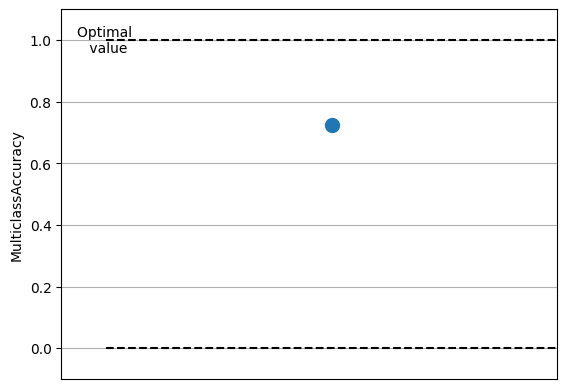

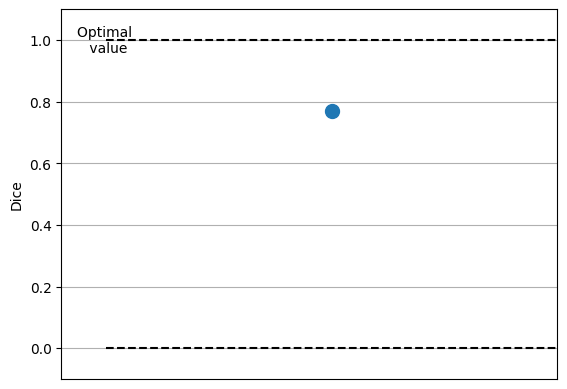

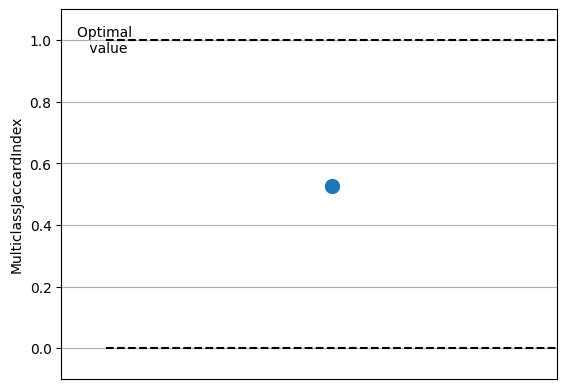

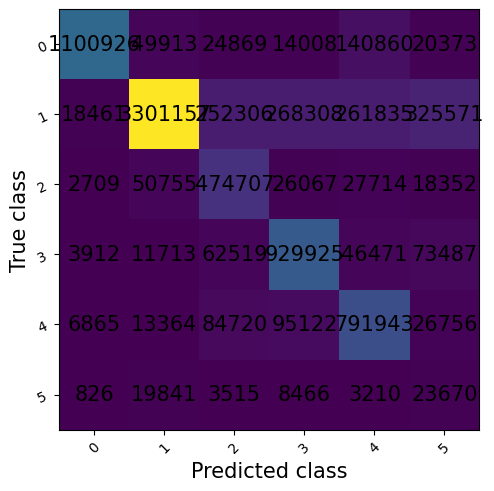

In [21]:
metrics_list = predict(model = model,
                       dataloader = test_dataloader,
                       num_classes = att_unet_hyperparams.NUM_CLASSES,
                       device = att_unet_hyperparams.DEVICE)